In [1]:
# import
import model_construction_cts as mc

## 1. Load Data and Initial Train/Test Split

In [2]:
X_trainval, X_test, y_trainval, y_test = mc.load_and_prepare_data('/Users/linh/Documents/Programming/Python/PIC 16B/Final Project/final_merged_data.csv', test_size=0.20)

## 2. Feature Selection via Lasso (on Train+Val only)

In [3]:
# Apply z-score standardization since Lasso’s penalty term (the L1 norm on coefficients) is scale‐sensitive
X_trainval_scaled, _, _= mc.standardization(X_trainval)

In [4]:
# Perform Lasso to extract nonzero coefficients
lasso_model, selected_features = mc.lasso_feature_selection(X_trainval_scaled, y_trainval)

Optimal alpha is 0.00005
Selected features and coefficients:
pct_renters         -0.000526
median_age          -0.003713
pct_female           0.002056
pct_age_65_plus      0.007580
pct_college_grads    0.000352
pct_unemployed      -0.000083
pct_nilf            -0.001820
median_income       -0.003922
dtype: float64


## 3. Restrict to Selected Features and Split Train/Validation

In [5]:
# Get reduced training‐validation
X_trainval_sel = X_trainval[selected_features.index.to_list()].copy()
y_trainval_sel = y_trainval.copy()

# Now split into train (80% of 80% = 64% total) and val (20% of 80% = 16% total)
X_train, X_val, y_train, y_val = mc.train_test_split(X_trainval_sel, y_trainval_sel, test_size = 0.2, random_state = 42)

## 4. Standardize Features

We need standardization to ensure every downstream model uses exactly the same preprocessed features. This consistency avoids leakage.

In [6]:
# Standardize X_train, X_val, and X_test using only train stats
X_train_scaled, train_means, train_stds = mc.standardization(X_train)

# Apply those same means & stds to validation and test
X_val_scaled, _, _  = mc.standardization(X_val, means = train_means, stds = train_stds)
X_test_scaled, _, _ = mc.standardization(X_test[selected_features.index.to_list()], means = train_means, stds = train_stds)

# Rescale the entire train+val block using train_means and train_stds
X_trainval_sel_scaled, _, _ = mc.standardization(X_trainval_sel, means = train_means, stds  = train_stds)

## 5. Model Construction

Before training any models, we need a consistent way to judge how well each model predicts the net total migration rate. For that, we will use root‐mean‐squared error as our primary performance metric. 
$$
\mathrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \bigl(y_i - \hat{y}_i\bigr)^{2}}
$$
 RMSE penalizes larger errors more heavily and is expressed in the same units as the target. In practice, a lower RMSE indicates that, on average, our predictions are closer to the actual migration rates. By comparing RMSE across Random Forest, Gradient Boosting, and our MLP, we can directly see which model yields the smallest average prediction error.

### a. Random Forest Model

In [7]:
# Grid‐search over n_estimators and max_depth to find best parameters
n_estimators_list = [50, 100, 150]
max_depth_list = [4, 6, 8, 10, 12]

rf_df = mc.grid_search_random_forest(X_train_scaled, y_train, X_val_scaled, y_val, n_estimators_list, max_depth_list)

Random Forest grid-search results:
    n_estimators  max_depth  rmse_val
0            100         12  0.004996
1            150         12  0.005011
2            100         10  0.005040
3            150         10  0.005056
4             50         10  0.005114
5            100          8  0.005116
6             50         12  0.005129
7            150          8  0.005133
8             50          8  0.005191
9            100          6  0.005315
10           150          6  0.005340
11            50          6  0.005395
12           100          4  0.005618
13           150          4  0.005625
14            50          4  0.005626


In [8]:
# Fit with best params and print out RMSE
rf_model, rf_rmse = mc.fit_best_random_forest(X_trainval_sel_scaled, y_trainval_sel, X_test_scaled, y_test, rf_df)

Random Forest Test RMSE: 0.00572


### b. Gradient Boosting Model

In [9]:
# Grid‐search over learning rate list, max depth_list, and n estimators list to find best parameters
learning_rate_list = [0.01, 0.05, 0.1]
max_depth_list = [3, 5]
n_estimators_list = [100, 200]

gbm_df = mc.grid_search_gradient_boosting(X_train_scaled, y_train, X_val_scaled, y_val, learning_rate_list, max_depth_list, n_estimators_list)

Gradient Boosting grid search results:
    learning_rate  max_depth  n_estimators  rmse_val
0            0.05          3           200  0.005603
1            0.05          3           100  0.005650
2            0.10          3           200  0.005943
3            0.01          3           200  0.005992
4            0.10          3           100  0.005996
5            0.01          3           100  0.006015
6            0.05          5           100  0.006146
7            0.10          5           100  0.006174
8            0.01          5           100  0.006225
9            0.05          5           200  0.006238
10           0.10          5           200  0.006284
11           0.01          5           200  0.006571


In [10]:
# Fit best‐found Gradient Boosting and evaluate on test
final_gbm, gbm_rmse = mc.fit_best_gradient_boosting(X_trainval_sel_scaled, y_trainval_sel, X_test_scaled, y_test, gbm_df)

Gradient Boosting Test RMSE: 0.00518


### c. MLP Model

We started with a basic MLP that was overfitting and yielding around 0.009 RMSE on the test set. To drive RMSE down, we switched to a “funnel” architecture (32→16→8 hidden units) and added 20 % dropout after each layer so the network couldn’t memorize noise. We also trained on the entire train+val block for 100 epochs with a larger batch size (64) to smooth out gradient updates. By monitoring the training‐RMSE curve, we confirmed the model continued improving without collapse, and the final test‐set evaluation produced the lowest RMSE I’ve seen (~ 0.005).

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 961 (3.75 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2231 - rmse: 0.4718  
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1283 - rmse: 0.3563
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0694 - rmse: 0.2622
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0410 - rmse: 0.2022
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0399 - rmse: 0.1990
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0256 - rmse: 0.1595
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0164 - rmse: 0.1276
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0100 - rmse: 0.0998
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0129 - rmse: 0.1131
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102 - rmse: 0.1006
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - rmse: 0.0890
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 0.0077 - rmse: 0.0865
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s

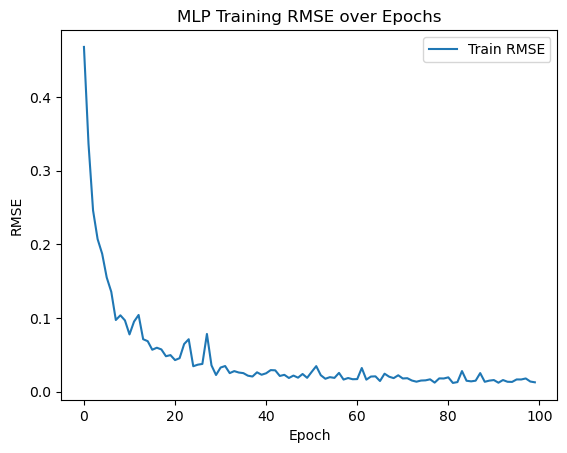



Evaluation on test set:
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2464e-05 - rmse: 0.0057 
MLP Test RMSE: 0.00578


In [11]:
# Train on the entire train+val block for a fixed number of epochs, plot the training RMSE vs. epochs, and Evaluate on the test set
mlp_model, mlp_rmse = mc.train_evaluate_mlp(X_trainval_sel_scaled, y_trainval_sel, 
                                            X_test_scaled, y_test, 
                                            input_dim=X_trainval_sel_scaled.shape[1], 
                                            epochs = 100, batch_size = 64)

## 6. Conclusion
After evaluating all three models on our hold‐out test set, we found that Gradient Boosting achieved the lowest RMSE (0.00518), while both Random Forest and our MLP tied at 0.00572. Although the difference is only a few thousandths, Gradient Boosting appears to capture the nonlinear relationships in our features slightly better. 

That said, there are still areas where we could improve: our hyperparameter searches were fairly limited, and we only trained a single neural network architecture without cross‐validating the MLP’s learning rate, layer sizes, or regularization. Because we only had 424 training samples, our MLP risked overfitting, and a more systematic K‐fold validation—or adding additional interaction or lagged features—might help all models generalize even further. In future work, we should also experiment with a wider grid of tree depths and learning rates (for both RF and GBM), or explore ensembling multiple models. Overall, Gradient Boosting is our best performer right now, but with more rigorous tuning and additional data engineering, we could likely push the RMSE down even further.